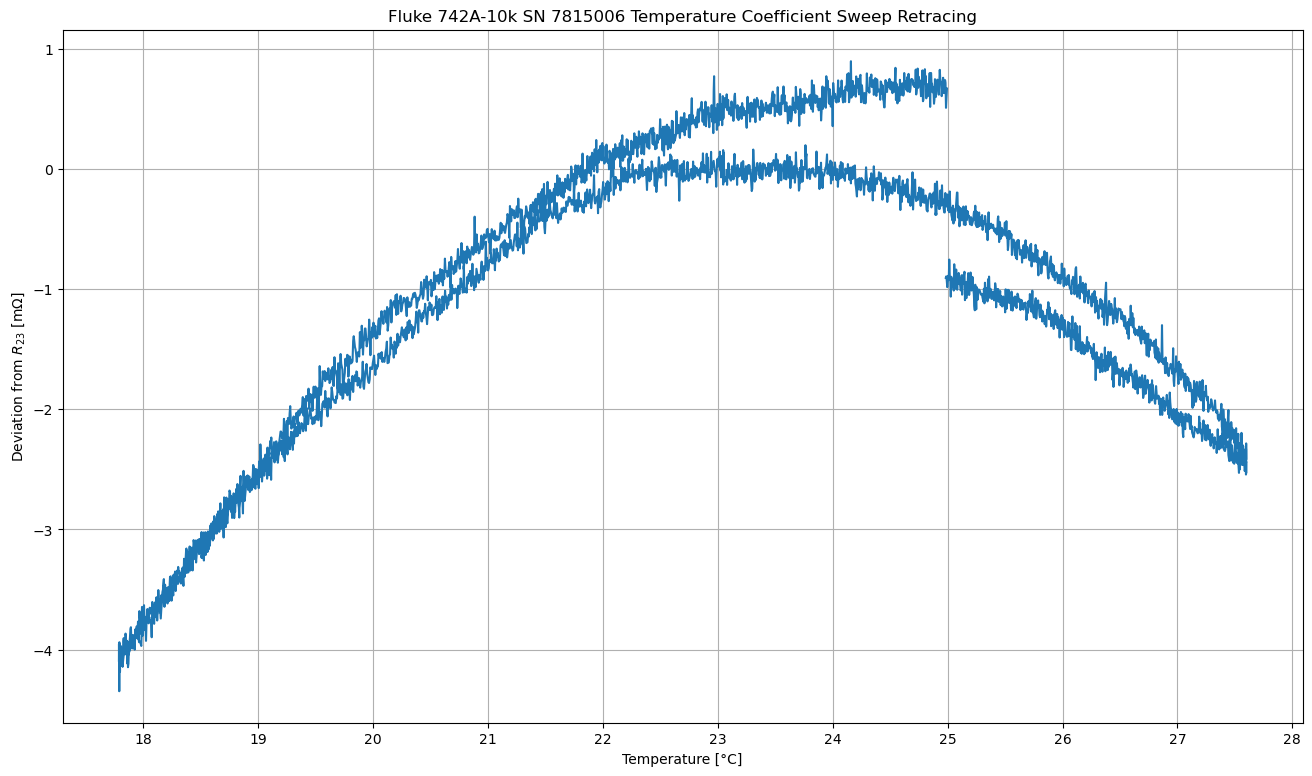

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('https://raw.githubusercontent.com/marcoreps/resistors/refs/heads/main/csv/742a_10k_TCR_sweep_18_23.csv', names=['time', 'DUT_temperature', 'resistance'], skiprows=1)

df=df.interpolate()


temperature=df[400:-50].DUT_temperature

resistance=(df[400:-50].resistance-10000.15965)*1000



fig,ax = plt.subplots(figsize=(16,9))
plt.xlabel('Temperature [°C]')
plt.ylabel(r'Deviation from $R_{23}$ [mΩ]')
ax.set_xticks(np.arange(18, 28.1, 1))
plt.grid(True, which="both")
plt.title('Fluke 742A-10k SN 7815006 Temperature Coefficient Sweep Retracing')
plt.plot(temperature, resistance)

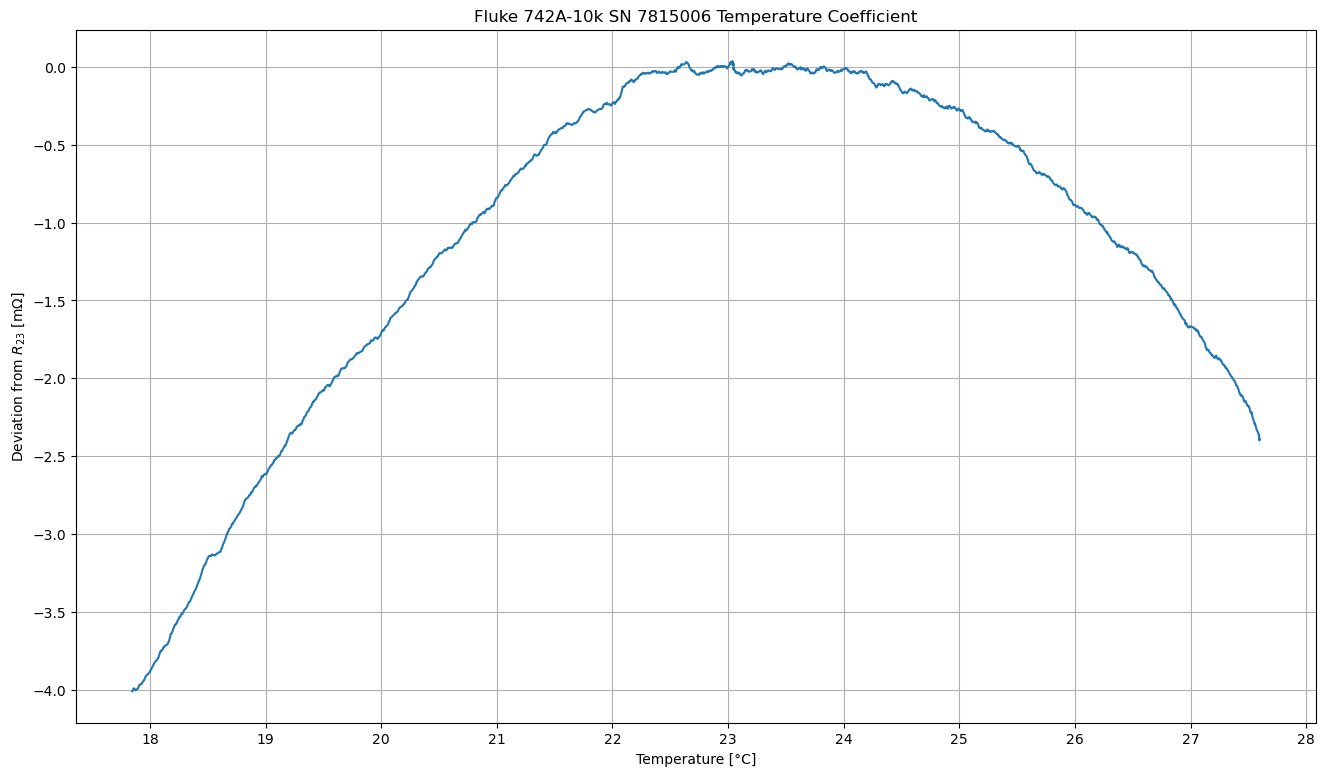

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('https://raw.githubusercontent.com/marcoreps/resistors/refs/heads/main/csv/742a_10k_TCR_sweep_18_23.csv', names=['time', 'DUT_temperature', 'resistance'], skiprows=1)

df=df.interpolate()


temperature=df[1990:-700].DUT_temperature

resistance=df.resistance.rolling(window=20).mean()
resistance=(resistance[1990:-700]-10000.15965)*1000

fig,ax = plt.subplots(figsize=(16,9))
plt.xlabel('Temperature [°C]')
plt.ylabel(r'Deviation from $R_{23}$ [mΩ]')
ax.set_xticks(np.arange(18, 28.1, 1))
plt.grid(True, which="both")
plt.title('Fluke 742A-10k SN 7815006 Temperature Coefficient')
plt.plot(temperature, resistance)

Measured α(23) = 0.011934936253958108 ppm/°C
Label α(23) = 0 ppm/°C
Measured β = -0.013285767586548614 ppm/°C²
Label β = -0.032 ppm/°C²
𐤃Nominal at 23°C = +15.963 ppm perhaps
Temperature at α0 = 23.449162465631332
Test current 500uA


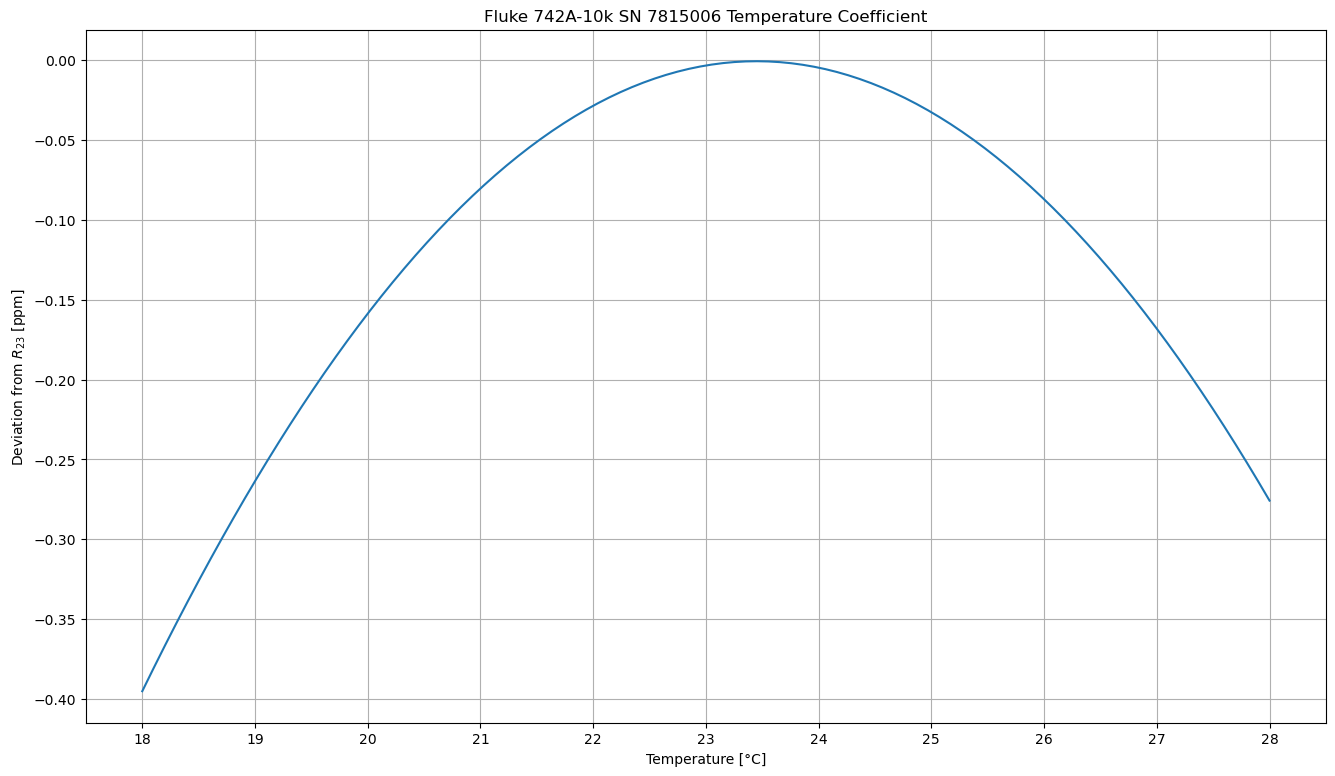

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev
from numpy.polynomial.chebyshev import chebfit

df=pd.read_csv('https://raw.githubusercontent.com/marcoreps/resistors/refs/heads/main/csv/742a_10k_TCR_sweep_18_23.csv', names=['time', 'DUT_temperature', 'resistance'], skiprows=1)

df=df.interpolate()


temperature=df[1990:-700].DUT_temperature

resistance=df.resistance.rolling(window=20).mean()
resistance=(resistance[1990:-700]-10000.15967)*100

fig,ax = plt.subplots(figsize=(16,9))
plt.xlabel('Temperature [°C]')
plt.ylabel(r'Deviation from $R_{23}$ [ppm]')
ax.set_xticks(np.arange(18, 28.1, 1))
plt.grid(True, which="both")
plt.title('Fluke 742A-10k SN 7815006 Temperature Coefficient')
#plt.plot(temperature, resistance)

polyfunction = Chebyshev.fit(temperature, resistance, deg=2)
xpoints = np.linspace(18, 28, 100)
plt.plot(xp, polyfunction(xpoints))
derivative=polyfunction.deriv()
print("Measured α(23) = "+str(derivative(23))+" ppm/°C")
print("Label α(23) = 0 ppm/°C")
#plt.plot(xpoints, xpoints*derivative(23)-0.274)
print("Measured β = "+str((((polyfunction(28)+polyfunction(18))/2)-polyfunction(23))/25)+" ppm/°C²")
print("Label β = -0.032 ppm/°C²")
print("𐤃Nominal at 23°C = +15.963 ppm perhaps")
print("Temperature at α0 = "+str(np.real(polyfunction.roots()[0])))
print("Test current 500uA")


Measured α(23) = -0.01017093572704848 ppm/°C
Label α(23) = 0.000 ppm/°C
Measured β = -0.027983555170067117 ppm/°C²
Label β = -0.032 ppm/°C²
𐤃Nominal at 23°C = +16 ppm perhaps
Temperature at α0 = 22.818269414597754
Test current 100uA (Fluke 8508A)
Target °C per hour = 0.07


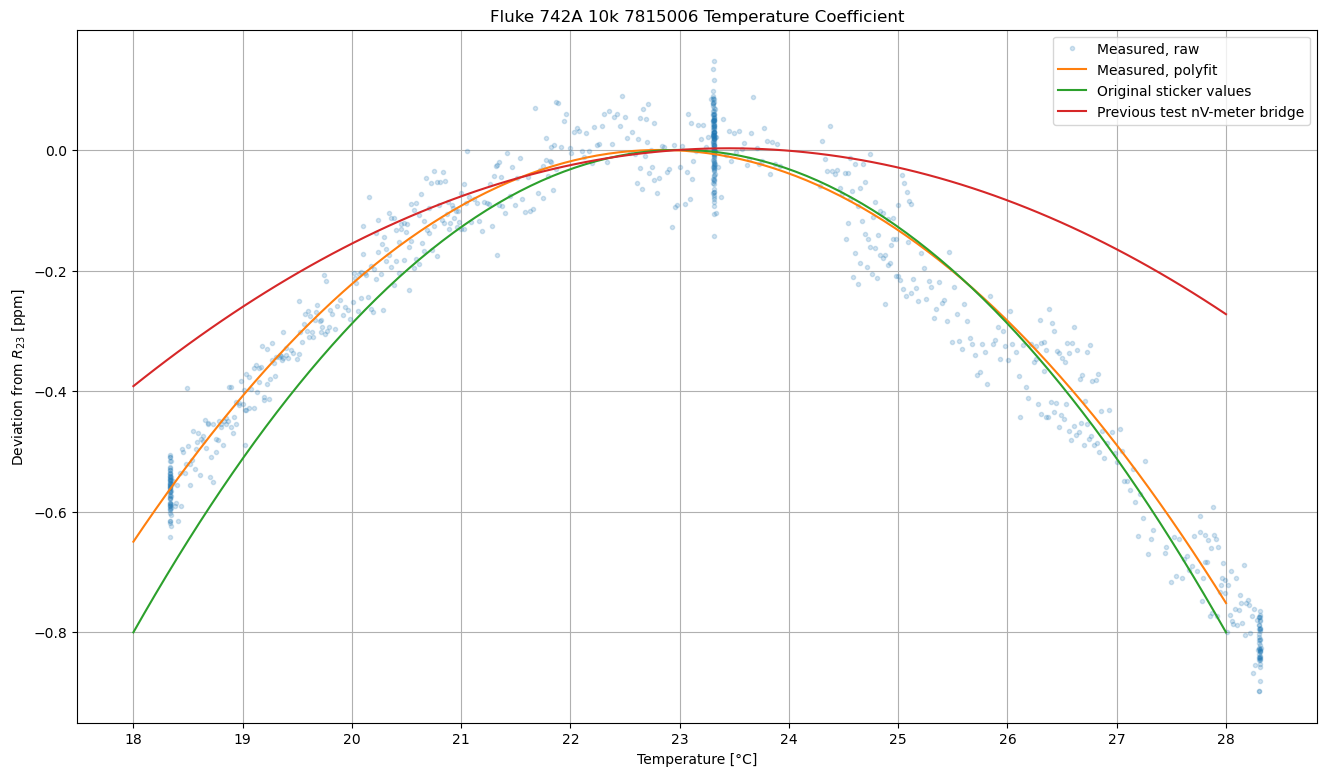

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev

df=pd.read_csv('https://raw.githubusercontent.com/marcoreps/resistors/refs/heads/main/csv/742a_10k_another_TCR_sweep_18_23_all_raw.csv', names=['Time', 'temp_ambient', 'temp_chamber', 'F742A_DUT', 'SR104_ambient', 'SR104_thermistor', '742_casing_pt100', 'VHP10k_DUT'], skiprows=1)

# We have one data point per time row, lets merge these into one row every 20m
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df = df.resample('20min').mean()
df = df.dropna(how='any')



# Lets look only at points where ambient temp is good
temp_threshold = 1
temp_mask = (df['temp_ambient'] >= (23.00 - temp_threshold)) & \
            (df['temp_ambient'] <= (23.00 + temp_threshold))
filtered_df = df[temp_mask].copy()
#filtered_df = df


# Correcting DMM measurements based on SR104_ambient and SR104_thermistor
SR104_best_guess = 1.00000500E+04
SR104_alpha = -0.04240
SR104_beta = -0.02552
filtered_df['dmm_correction_factor'] = ((SR104_best_guess*(   1.0+(SR104_alpha/1000000.0)*((filtered_df['SR104_thermistor']-10000.0)/10.0) + (SR104_beta/1000000.0)*((filtered_df['SR104_thermistor']-10000.0)/10.0)**2.0 ))/ filtered_df['SR104_ambient'])
filtered_df['corrected_F742A_DUT']=filtered_df['F742A_DUT']*filtered_df['dmm_correction_factor']



# Polyfit
polyfunction = Chebyshev.fit(filtered_df['742_casing_pt100'], filtered_df['corrected_F742A_DUT'], deg=2)

# Prepare the plot
fig,ax = plt.subplots(figsize=(16,9))
plt.xlabel('Temperature [°C]')
plt.ylabel(r'Deviation from $R_{23}$ [ppm]')
ax.set_xticks(np.arange(18, 28.1, 1))
plt.grid(True, which="both")
plt.title('Fluke 742A 10k 7815006 Temperature Coefficient')
xpoints = np.linspace(18, 28, 100)
maximum = max(polyfunction(xpoints))

# Optionally indicate underlying data points
plt.plot(filtered_df['742_casing_pt100'], (filtered_df['corrected_F742A_DUT']-maximum)*100, '.', alpha=0.2, label='Measured, raw')

# Plot our polyfunction between 18 and 28°C
plt.plot(xpoints, (polyfunction(xpoints)-maximum)*100, label='Measured, polyfit')

# Optionally indicate original values
orig_maximum = max(0.0*(xpoints-23)-0.032*(xpoints-23)*(xpoints-23))
plt.plot(xpoints, (0.0*(xpoints-23)-0.032*(xpoints-23)*(xpoints-23)-orig_maximum), label='Original sticker values')

# Optionally indicate results from previous test
previous_maximum = max(0.01193*(xpoints-23)-0.013285*(xpoints-23)*(xpoints-23))
plt.plot(xpoints, (0.01193*(xpoints-23)-0.013285*(xpoints-23)*(xpoints-23)-orig_maximum), label='Previous test nV-meter bridge')

# LFG
plt.legend()

# Optionally print some more stats
derivative=polyfunction.deriv()
print("Measured α(23) = "+str(derivative(23)*100)+" ppm/°C")
print("Label α(23) = 0.000 ppm/°C")
#plt.plot(xpoints, xpoints*derivative(23)-0.274)
print("Measured β = "+str(((((polyfunction(28)+polyfunction(18))/2)-polyfunction(23))/25)*100)+" ppm/°C²")
print("Label β = -0.032 ppm/°C²")
print("𐤃Nominal at 23°C = +16 ppm perhaps")
print("Temperature at α0 = "+str(np.real(polyfunction.deriv().roots()[0])))
print("Test current 100uA (Fluke 8508A)")
print("Target °C per hour = 0.07")

